In [1]:
from pathlib import Path
import importlib
import open3d as o3d
import numpy as np
import cv2
import matplotlib.pyplot as plt
from src import object_render
importlib.reload(object_render)
from src import model_save_load
importlib.reload(model_save_load)
from src import object_detection
importlib.reload(object_detection)
from src import bbox_utils
importlib.reload(bbox_utils)


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


/home/be2r-lab-210134/Python/anaconda3/envs/point_cloud/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/be2r-lab-210134/Python/anaconda3/envs/point_cloud/lib/python3.9/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/home/be2r-lab-210134/Python/anaconda3/envs/point_cloud/lib/python3.9/site-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/67

<module 'src.bbox_utils' from '/home/be2r-lab-210134/Python/functional_grasp/11.04.2025/Affordance/src/bbox_utils.py'>

In [2]:
data_dir = Path("./data/hammer")
mesh_file = data_dir / "object_convex_decomposition.obj"
mesh_o3d, mesh_trimesh, info = model_save_load.load_mesh(mesh_file, vis=False)

In [ ]:
object_render.get_render([1,1,0], 30, mesh_o3d, data_dir/"example")

In [53]:


azimuth_samples = np.linspace(0,360,20,endpoint=False)
elevation_cos = np.linspace(-1,1,10,endpoint=True)
elevation_samples = (np.rad2deg(np.arccos(elevation_cos))).astype("int32")
rotation_samples = np.linspace(0, 360, 20,endpoint=False)


In [ ]:
elevation_samples

In [54]:
for elevation in elevation_samples:
    if elevation==0 or elevation==180:
        for rot in rotation_samples:
            object_render.get_render([0,0,np.cos(np.radians(elevation))], rot, mesh_o3d,data_dir/"renders")
    else:
        for azimuth in azimuth_samples:
            for rot in rotation_samples:
                object_render.get_render([np.cos(np.radians(azimuth))*np.sin(np.radians(elevation)),np.sin(np.radians(azimuth))*np.sin(np.radians(elevation)),np.cos(np.radians(elevation))], rot, mesh_o3d,data_dir/"renders")


In [26]:
render_dir = data_dir/"renders"
render_iter = render_dir.glob("render_*")
path_list= list(render_iter)
len(path_list)

3240

In [4]:
image = cv2.imread(next(render_iter))
bbox = object_detection.detect_object_with_opencv(image, vis =True)
croped_image = bbox_utils.crop_bbox_cv2(image,bbox)

# cv2.imshow('Matches', image)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

StopIteration: 

In [25]:
image = cv2.imread(data_dir/"mask.png")
image = bbox_utils.add_bbox_to_image(image, np.array([225, 158, 275, 222]))
bbox = bbox_utils.get_total_bounding_box(image,background_white=True)
croped_image_scene = bbox_utils.crop_bbox_cv2(image,bbox)

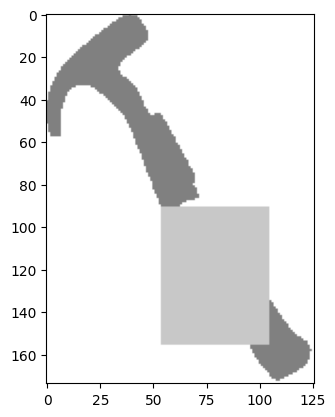

In [6]:
plt.imshow(croped_image_scene)

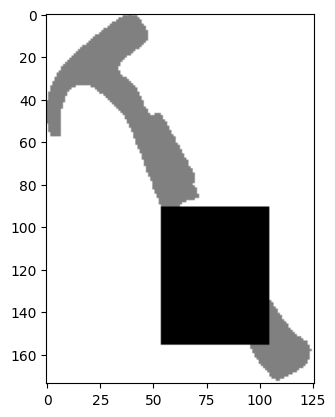

In [7]:

mask = np.all(croped_image_scene==np.array([200,200,200]), axis=-1)
croped_image_scene[mask] = [0, 0, 0]
plt.imshow(croped_image_scene) 

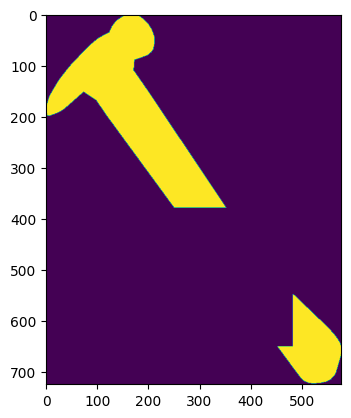

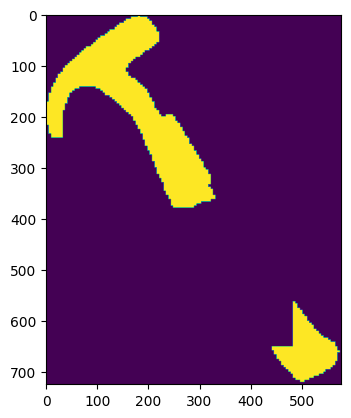

0.707133291382287

In [60]:
image = cv2.imread(path_list[max_ind])
bbox = object_detection.detect_object_with_opencv(image, vis = False)
croped_image = bbox_utils.crop_bbox_cv2(image,bbox)
score, mask = comparison_score(croped_image, croped_image_scene, vis=True)
score



In [ ]:
comparison_score(croped_image, croped_image_scene)

In [27]:
max_score = -np.inf
max_ind = -1
max_mask = None
cropped = None
max_bbox = None
for i, path in enumerate(path_list):
    image = cv2.imread(path)
    bbox = object_detection.detect_object_with_opencv(image, vis = False)
    croped_image = bbox_utils.crop_bbox_cv2(image,bbox)
    score, mask = comparison_score(croped_image, croped_image_scene)
    if score > max_score:
        max_ind = i
        max_mask = mask
        cropped = croped_image 
        max_score = score
        max_bbox = bbox



In [35]:
image.shape[:2]
x_min,y_min, x_max,y_max = max_bbox
initial_mask = np.zeros(image.shape[:2])
initial_mask[y_min:y_max+1,x_min:x_max+1] = max_mask


In [38]:
initial_mask.astype("int32")

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)

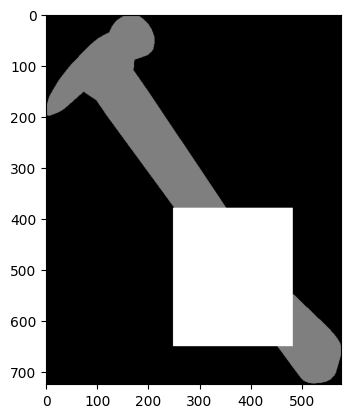

In [11]:
cropped[max_mask] = [255, 255, 255]
plt.imshow(cropped)

In [12]:
np.save(data_dir/"mask.npy", mask)


In [21]:
depth = o3d.io.read_image(depth_path)
type(depth)

open3d.cuda.pybind.geometry.Image

In [19]:
np.asarray(depth)

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint16)

In [39]:
o3d.io.write_image(data_dir/"masked_depth.png",o3d.geometry.Image(np.asarray(depth)[initial_mask.astype("int32")]))


: 

In [13]:
render_dir = data_dir/"renders"
render_iter = render_dir.glob("depth_*")
path_list= list(render_iter)
len(path_list)

3240

In [14]:
depth_path = path_list[max_ind]